In [1]:
%matplotlib inline
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

### Implicit Multithreading in NumPy

#### A Matrix Operation

In [2]:
n = 20
m = 1000

for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

#### A Multithreaded Ufunc

In [3]:
def f(x, y):

    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 5000)
x, y = np.meshgrid(grid, grid)

In [4]:
%timeit np.max(f(x, y))

756 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### A Comparison with Numba

In [5]:
from numba import vectorize

@vectorize
def f_vec(x, y):

    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y)) # Run once to compile

0.9999992797121728

In [6]:
%timeit np.max(f_vec(x, y))

266 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading a Numba Ufunc

In [7]:
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):

    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y)) # Run once to compile

0.9999992797121728

In [8]:
%timeit np.max(f_vec(x, y))

209 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Multithreaded Loops in Numba

In [9]:
from numpy.random import randn
from numba import njit

@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    """
    Updates household wealth.
    """

    # Draw shocks
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())

    # Update wealth
    w = R * s * w + y

    return w

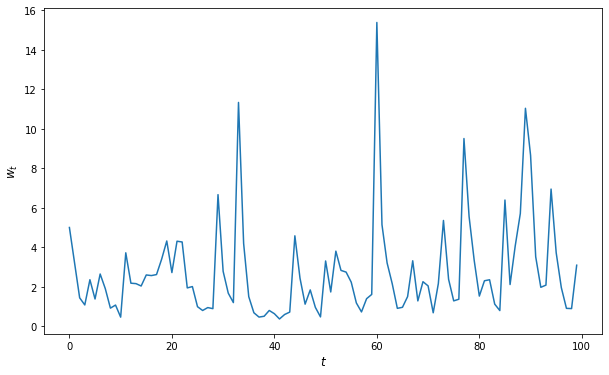

In [10]:
fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5

for t in range(T-1):
    w[t+1] = h(w[t])

ax.plot(w)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$w_{t}$', fontsize=12)
plt.show()

In [11]:
@njit
def compute_long_run_median(w0=1, T=1000, num_reps=50_000):
    obs = np.empty(num_reps)

    for i in range(num_reps):
        w = w0
    
        for t in range(T):
            w = h(w)

        obs[i] = w
        
    return np.median(obs)

In [12]:
%%time
compute_long_run_median()

CPU times: total: 6 s
Wall time: 6.13 s


1.8415698962496327

In [13]:
from numba import prange

@njit(parallel=True)
def compute_long_run_median_parallel(w0=1, T=1000, num_reps=50_000):
    obs = np.empty(num_reps)
    
    for i in prange(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        
        obs[i] = w
    
    return np.median(obs)

In [14]:
%%time
compute_long_run_median_parallel()

CPU times: total: 8.72 s
Wall time: 2.28 s


1.842959543482572

### Exercises

In [15]:
from random import uniform

@njit(parallel=True)
def calculate_pi(n=1_000_000):
    count = 0
    for i in prange(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1
    
    area_estimate = count / n
    
    return area_estimate * 4 # dividing by radius**2

In [16]:
%time calculate_pi()

CPU times: total: 578 ms
Wall time: 611 ms


3.143952

In [17]:
%time calculate_pi()

CPU times: total: 0 ns
Wall time: 8.97 ms


3.142596

In [18]:
from numpy.random import randn

M = 10_000_000
n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@njit(parallel=True)
def compute_call_price_parallel(β = β,
                                μ = μ,
                                S0 = S0,
                                h0 = h0,
                                K = K,
                                n = n,
                                ρ = ρ,
                                ν = ν,
                                M = M):

    current_sum = 0.0

    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0

        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()

        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

### End.